# Time Evolution using Renormalizer

## Overview

In this notebook we will simulate the charge transfer between two molecules using the Marcus model

$$
    \hat H = -V(a^\dagger_0 a_1 + a^\dagger_1 a_0) + \Delta G a^\dagger_1 a_1 + \omega \sum_{i=0, 1} b^\dagger_i b_i + g \omega \sum_{i=0, 1} a^\dagger_i a_i (b^\dagger_i + b_i)
$$

with transfer integral $V=-0.1$, dimensionless coupling constant $g=1$, vibration frequency $\omega=0.5$.

We will first show how to use Renormalizer to simulation the time evolution at $\Delta G = 0$.
Then, we will show that, by decreasing the reaction Gibbs free energy change $\Delta G$, the reaction rate will first increase and then decrease, as predicted by the Marcus theory.

## Preparation: Setting Up Logger

In [1]:
from renormalizer.utils.log import package_logger as logger

2025-08-12 19:53:51,945[INFO] Use NumPy as backend
2025-08-12 19:53:51,946[INFO] use 64 bits


In [2]:
logger.debug("logger output")

2025-08-12 19:53:51,971[DEBUG] logger output


In [3]:
from renormalizer.utils.log import set_stream_level, INFO

In [4]:
# filter logger output
set_stream_level(INFO)

In [5]:
logger.debug("This message will not be shown")

In [6]:
logger.info("Logger output")

2025-08-12 19:53:52,024[INFO] Logger output


## Define the Model and Initial State

In [7]:
from renormalizer import Op, BasisMultiElectron, BasisSHO, Model
import numpy as np

In [8]:
v = -0.1
g = 1
omega = 0.5
nbas = 16

In [9]:
def get_model(delta_g):
    ham_terms = v * Op(r"a^\dagger a", ["e0", "e1"]) + v * Op(r"a^\dagger a", ["e1", "e0"])
    ham_terms += delta_g * Op(r"a^\dagger a", "e1")
    for i in range(2):
        ham_terms += omega * Op(r"b^\dagger b", f"v{i}")
        ham_terms += g * omega * Op(r"a^\dagger a", f"e{i}") * Op(r"b^\dagger+b", f"v{i}")
    basis = [BasisMultiElectron(["e0", "e1"], [0, 0]), BasisSHO("v0", omega, nbas), BasisSHO("v1", omega, nbas)]
    return Model(basis, ham_terms)

In [10]:
# using a relaxed initial state
def get_init_condition():
    basis = BasisSHO(0, omega, nbas)
    state = np.linalg.eigh(basis.op_mat(r"b^\dagger b") + g * basis.op_mat(r"b^\dagger+b"))[1][:, 0]
    return {"v0": state}
init_condition = get_init_condition()

## Time Evolution with the Default Configuration
Next, we run the simulation using the `evolve` method in the `Mps` class. At this phase, we keep $\Delta G = 0$. 

In [11]:
delta_g = 0
model = get_model(delta_g)

In [12]:
from renormalizer import Mps, Mpo

In [13]:
# Hamiltonian MPO
mpo = Mpo(model)
# The occupation of e0
n_op = Mpo(model, Op(r"a^\dagger a", "e0"))

In [14]:
# initialize the MPS
mps = Mps.hartree_product_state(model, condition=init_condition)
# time evolution step
dt = 0.2
# record the electronic occupation
n_list = []
for i_step in range(50):
    n = mps.expectation(n_op)
    logger.info(f"Step {i_step}. Time {i_step * dt:.2f}. $n$ {n}")
    # perform time evolution. Note that the evolution is not in-place.
    mps = mps.evolve(mpo, dt)
    n_list.append(n)

2025-08-12 19:53:52,132[INFO] Step 0. Time 0.00. $n$ 0.9999999999999997
2025-08-12 19:53:52,142[INFO] Step 1. Time 0.20. $n$ 0.9996030537865598
2025-08-12 19:53:52,152[INFO] Step 2. Time 0.40. $n$ 0.9984313966561621
2025-08-12 19:53:52,161[INFO] Step 3. Time 0.60. $n$ 0.996553287645058
2025-08-12 19:53:52,184[INFO] Step 4. Time 0.80. $n$ 0.994073136263905
2025-08-12 19:53:52,209[INFO] Step 5. Time 1.00. $n$ 0.9911161868842486
2025-08-12 19:53:52,239[INFO] Step 6. Time 1.20. $n$ 0.9878132450238745
2025-08-12 19:53:52,264[INFO] Step 7. Time 1.40. $n$ 0.9842873078294335
2025-08-12 19:53:52,291[INFO] Step 8. Time 1.60. $n$ 0.9806441927926955
2025-08-12 19:53:52,315[INFO] Step 9. Time 1.80. $n$ 0.9769677466243794
2025-08-12 19:53:52,338[INFO] Step 10. Time 2.00. $n$ 0.9733182226560809
2025-08-12 19:53:52,369[INFO] Step 11. Time 2.20. $n$ 0.9697373081106367
2025-08-12 19:53:52,393[INFO] Step 12. Time 2.40. $n$ 0.9662497016753396
2025-08-12 19:53:52,416[INFO] Step 13. Time 2.60. $n$ 0.9628671

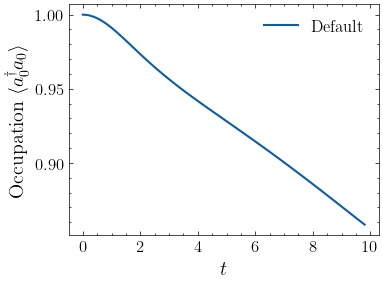

In [15]:
# plotting the occupation
from matplotlib import pyplot as plt
plt.style.use("mm.mplstyle")

plt.plot(np.arange(len(n_list)) * dt, n_list, label="Default")
plt.xlabel("$t$")
plt.ylabel(r"Occupation $\langle a^\dagger_0 a_0 \rangle$")
plt.legend()
plt.show()

In this example, the time evolution is performed with default time evolution configuration and MPS compression configuration.

Renormalizer by default uses the RK4 "propagation and compression" method for time evolution.
The advantage of the method is that it is easy to understand and setup. 

> Please refer to our [recent review](https://weitangligroup.com/pdf/2022time.pdf) for a discussion of the different time evolution schemes.

In [16]:
mps.evolve_config.method

<EvolveMethod.prop_and_compress: 'P&C'>

Regarding MPS compression/truncation configuration, Renormalizer by default employs a truncation scheme based on the the singular value threshold.

In [17]:
mps.compress_config.criteria, mps.compress_config.threshold

(<CompressCriteria.threshold: 'threshold'>, 0.001)

Inspection of the dimension of the final mps after time evolution shows that the compression is efficient.

In [18]:
mps.bond_dims

[1, 2, 4, 1]

## Configuring Time Evolution
In order to configure the time evolution, you should update the `evolve_config` and `compress_config` attributes of an MPS instance. 
These attributes are instances of the `EvolveConfig` class and the `CompressConfig` class.
Please see the API referece for full options of the configuration classes.

In [19]:
from renormalizer.utils.configs import CompressConfig, CompressCriteria

In [20]:
# update the compresssion configuration. Adopt a fixed bond dimension of 8
mps.compress_config = CompressConfig(CompressCriteria.fixed, max_bonddim=8)

Next, we perform one more step of the time evolution, and the bond dimension in the middle of the MPS is increased from 4 to 8, according to the updated compression configuration.

In [21]:
new_mps = mps.evolve(mpo, dt)
new_mps.bond_dims

[1, 2, 8, 1]

Recent studies have shown that methods based on time dependent variantional principle (TDVP) show higher accuracy and efficiency.
In our production runs, we usually employ one-site TDVP with projector splitting (TDVP-PS) for time evolution.
TDVP-PS allows much larger time evolution step size and reduces memory consumption.
However, its setup is a little more complex than propagation and compression, since one-site TDVP generally can not adjust bond dimension during time evolution.

In [22]:
from renormalizer.utils.configs import EvolveConfig, EvolveMethod

In [23]:
mps.evolve_config = EvolveConfig(EvolveMethod.tdvp_ps)

Next, we perform one more step of the time evolution using TDVP-PS.

Note that the bond dimension in the middle of the MPS does not increase from 4 to 8.
This is because one-site TDVP-PS does not alter the bond dimension.

In order to perform one-site TDVP-PS time evolution, it is imperative to increase the bond dimension of the MPS first, and then perform the time evolution. 

In [24]:
new_mps = mps.evolve(mpo, dt)
new_mps.bond_dims

[1, 2, 4, 1]

The `expand_bond_dimension` function increases the bond dimension to target value specified by the `compress_config`.
In short, the function adds the vectors in the Krylov space $H^n|\psi\rangle$ to the input wavefunction $|\psi\rangle$, and then compresses it to the target bond dimension.

The `include_ex` option is specifically designed for systems with quantum number conservation. If the initial wavefunction does not include contributions from a certain symmetry sector, these contributions will not reappear during time evolution due to the projection error in TDVP.
Setting `include_ex=True` will add a small perturbation to the initial state to help recover the missing symmetry sector contributions.
In our case, the quantum number conservation is disabled, so we set `include_ex=False`.

In [25]:
new_mps = mps.expand_bond_dimension(mpo, include_ex=False)
new_mps.bond_dims

[1, 2, 10, 1]

## Observing Marcus Inverted Region

Next, we put everything together and perform time evolution with different $\Delta G$ using TDVP-PS.
Since the initial state of time evolution is a Hartree product state, we must expand the bond dimension before performing the time evolution.

In [26]:
# time evolution step
dt = 0.5

# initialize the MPS in the Hartree product state
init_mps = Mps.hartree_product_state(model, condition=init_condition)
logger.info(f"Initial MPS bond dimension: {init_mps.bond_dims}")
# setup compression configuration
init_mps.compress_config = CompressConfig(CompressCriteria.fixed, max_bonddim=8)
# setup time evolution configuration
init_mps.evolve_config = EvolveConfig(EvolveMethod.tdvp_ps)


# record the electronic occupation
n_list_list = []

delta_g_list = np.linspace(0, -2, 5)
for delta_g in delta_g_list:
    # reconstruct the Hamiltonian. We can reuse the occupation operator though
    model = get_model(delta_g)
    mpo = Mpo(model)
    # since using TDVP-PS, expand the bond dimension to target value.
    # otherwise the time evolution is limited to the Hartree product state.
    mps = init_mps.expand_bond_dimension(mpo, include_ex=False)
    logger.info(f"MPS bond dimension after expanding: {mps.bond_dims}")
    n_list = []
    for i_step in range(20):
        n = mps.expectation(n_op)
        logger.info(f"Step {i_step}. Time {i_step * dt:.2f}. $n$ {n}")
        # perform time evolution. Note that the evolution is not in-place.
        mps = mps.evolve(mpo, dt)
        n_list.append(n)
    n_list_list.append(n_list)

2025-08-12 19:53:54,695[INFO] Initial MPS bond dimension: [1, 1, 1, 1]
2025-08-12 19:53:54,748[INFO] MPS bond dimension after expanding: [1, 2, 8, 1]
2025-08-12 19:53:54,750[INFO] Step 0. Time 0.00. $n$ 0.9999999999999998
2025-08-12 19:53:54,765[INFO] Step 1. Time 0.50. $n$ 0.9975776788480686
2025-08-12 19:53:54,783[INFO] Step 2. Time 1.00. $n$ 0.9911341778168762
2025-08-12 19:53:54,800[INFO] Step 3. Time 1.50. $n$ 0.9824981838218428
2025-08-12 19:53:54,814[INFO] Step 4. Time 2.00. $n$ 0.973328341822762
2025-08-12 19:53:54,828[INFO] Step 5. Time 2.50. $n$ 0.9645218516417918
2025-08-12 19:53:54,844[INFO] Step 6. Time 3.00. $n$ 0.9563382368442357
2025-08-12 19:53:54,865[INFO] Step 7. Time 3.50. $n$ 0.948730433384314
2025-08-12 19:53:54,882[INFO] Step 8. Time 4.00. $n$ 0.9415533981846886
2025-08-12 19:53:54,898[INFO] Step 9. Time 4.50. $n$ 0.9346400325001772
2025-08-12 19:53:54,922[INFO] Step 10. Time 5.00. $n$ 0.927835184217773
2025-08-12 19:53:54,940[INFO] Step 11. Time 5.50. $n$ 0.9210

By plotting the figure, we see that when $\Delta G=-1$, the charge transfer rate is highest.

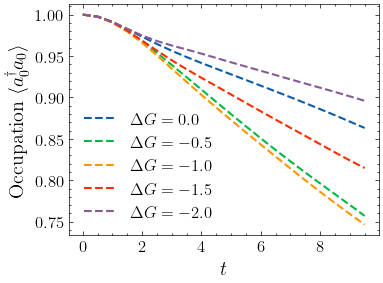

In [27]:
t = np.arange(len(n_list_list[0])) * dt
for i, n_list in enumerate(n_list_list):
    label = r"$\Delta G =" + str(delta_g_list[i]) + "$"
    plt.plot(t, n_list, label=label, linestyle="--")
plt.xlabel("$t$")
plt.ylabel(r"Occupation $\langle a^\dagger_0 a_0 \rangle$")
plt.legend()

The prediction is consistent with the Marcus theory ,where the Marcus rate is

$$
k = \frac{V^2}{\hbar} \sqrt{\frac{\pi\beta}{\lambda}} \exp{\left (-\frac{\beta(\lambda + \Delta G)^2}{4\lambda} \right )}
$$
Here $\lambda = 2g^2\omega = 1$ is the reorganization energy.

## Features of Time Evolution Schemes
Renormalizer has a lot of different time evolution schemes, the most commonly used ones are
1. Propagation and Compression: `EvolveMethod.prop_and_compress`
2. Single-site TDVP-PS: `EvolveMethod.tdvp_ps`
3. Two-site TDVP-PS: `EvolveMethod.tdvp_ps2`
4. TDVP with varianble mean field (VMF): `EvolveMethod.tdvp_vmf`

The features of these methods are as follows

| Name               | Accuracy | Computational Cost | Adaptive Step-Size | Adaptive Bond Dimension | Projection Error |
|--------------------|----------|--------------------|--------------------|-------------------------|------------------|
| `prop_and_compress`| Low      | High               | partial            | Yes                     | No               |
| `tdvp_ps`          | High     | Low                | No                 | No                      | Yes              |
| `tdvp_ps2`         | High     | High               | No                  | Yes                     | Partial         |
| `tdvp_vmf`         | High     | High               | Yes                 | No                      | Yes             |


"Adaptive Step-Size" refers to the ability to dynamically adjust the time-evolution step size based on a predefined error threshold. In practice, this means the method automatically takes smaller steps when the wavefunction changes abruptly and larger steps when it evolves smoothly. For example, `tdvp_vmf` performs multiple small steps within a single call to the `evolve` method. This capability removes the need for users to manually check step-size convergence in TD-DMRG by testing multiple step sizes.

"Adaptive Bond Dimension" refers to the ability to dynamically adjust the bond dimension during time evolution. Typically, the initial state is a Hartree product state. For `tdvp_ps` and `tdvp_vmf`, the `expand_bond_dimension` method should be called before starting the time evolution. Otherwise, the simulation will proceed with a bond dimension of 1 rather than the value specified in the optimization settings.

"Projection Error" is the error introduced when projecting the time derivative onto the MPS manifold.

Empirically, we recommend `tdvp_ps` for production level calculations.